In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
print("Running on PyMC3 v{}".format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

from libLN import LogNormalField
%run config_10.py

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict
import corner

Running on PyMC3 v3.9.3
Running on ArviZ v0.11.0
Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [3]:
# Set the seed for reproducibility
dataid=2
np.random.seed(seed+dataid)

# Load observed field

In [4]:
# Load data vector
LN=LogNormalField(Lside,rmax,nbin)
lognormfields=np.load(simsout+'.npy')
field_data = lognormfields[dataid]['field']

# Run data assimilation (inference with field-level likelihood)

In [5]:
# Sampler setup
nsamples = 10000
ntune = 5000
ncores = 16
target_accept = 0.80
init = 'advi'
output_trace = simsout+'/trace_'+str(dataid)+'_'+str(nsamples)+'_'+str(ntune)+'_'+str(ncores)+'_'+str(int(100*target_accept))+'_'+init

# Import pymc3 lognormal model from the LN library
LN_model = LN.pymc3_model(field_data,alphamin,alphamax,betamin,betamax,PixelNoise)

In [6]:
with LN_model:
    trace = pm.sample(nsamples, tune=ntune, cores=ncores, target_accept=target_accept,
                      init=init, discard_tuned_samples=False)

pm.save_trace(trace, output_trace, overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 38400
Interrupted at 38,399 [19%]: Average Loss = 3.7933e+05
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [gaussian, beta, alpha]


Sampling 16 chains for 5_000 tune and 10_000 draw iterations (80_000 + 160_000 draws total) took 177161 seconds.
The number of effective samples is smaller than 10% for some parameters.


'data/Sims20_05_10_80_80_500_80_1_123456/trace_2_10000_5000_16_80_advi'

# Analysis of the Markov chains

In [7]:
# Load the trace
with LN_model:
    trace = pm.load_trace(output_trace)

array([[<AxesSubplot:title={'center':'gaussian'}>,
        <AxesSubplot:title={'center':'gaussian'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

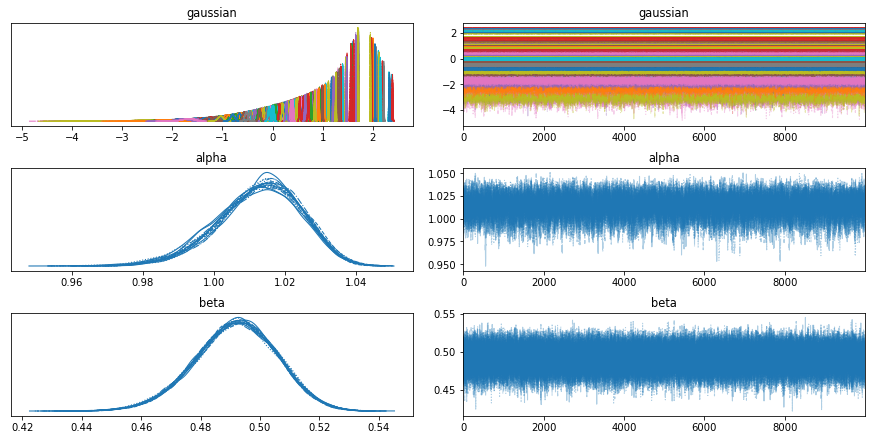

In [7]:
# Plot the traces
pm.traceplot(trace)

In [8]:
rhat=az.rhat(trace)
rhat

<xarray.Dataset>
Dimensions:         (gaussian_dim_0: 400)
Coordinates:
  * gaussian_dim_0  (gaussian_dim_0) int64 0 1 2 3 4 5 ... 395 396 397 398 399
Data variables:
    gaussian        (gaussian_dim_0) float64 1.0 1.0 1.0 1.001 ... 1.0 1.001 1.0
    alpha           float64 1.003
    beta            float64 1.0

In [9]:
# Compute the mean solutions, after an (arbitrary) burnin

gaussian_samples = trace.get_values('gaussian',burn=ntune)
alpha_samples = trace.get_values('alpha',burn=ntune)
beta_samples  = trace.get_values('beta',burn=ntune)
lognormal_samples = np.array([LN.G_to_LN(gaussian_samples[n], alpha_samples[n]).reshape(Lside,Lside) for n in range(len(alpha_samples))])

mean_gaussian = gaussian_samples.mean(axis=0)
mean_alpha    = alpha_samples.mean()
mean_beta     = beta_samples.mean()
mean_lognormal = lognormal_samples.mean(axis=0)

da_samples = np.stack([alpha_samples,beta_samples],axis=-1)
da_weights = np.ones((da_samples.shape[0]))
np.savez(dataout+'_da_'+str(dataid),samples=da_samples,weights=da_weights)

data=lognormfields[dataid]['field']
posterior_mean=mean_lognormal
difference=data-posterior_mean
rhat_field=np.array(rhat['gaussian']).reshape(Lside,Lside)
np.savez(dataout+'_da_fields_'+str(dataid),data=data,posterior_mean=posterior_mean,difference=difference,rhat_field=rhat_field)

print('Mean alpha, beta:',mean_alpha,mean_beta)
print('True alpha, beta:',alpha,beta)
print('Gelman-Rubin rhat alpha, beta:',float(rhat['alpha']),float(rhat['beta']))

Mean alpha, beta: 1.0127086671289935 0.49183363808539043
True alpha, beta: 1.0 0.5
Gelman-Rubin rhat alpha, beta: 1.0026306594881342 1.0002446205188171


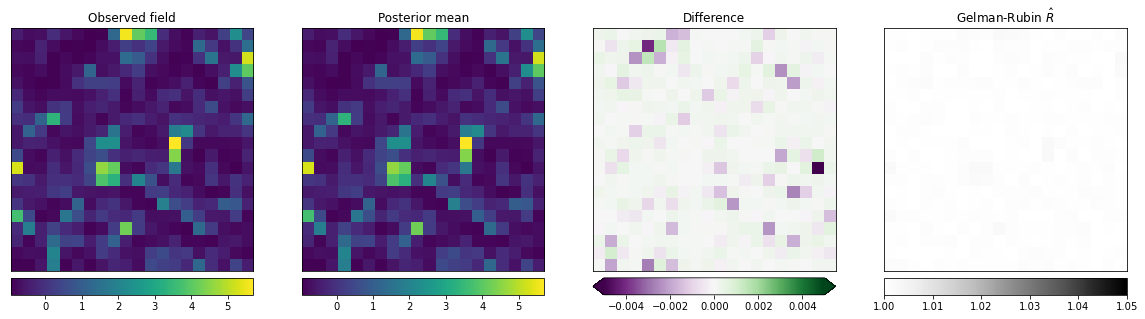

In [10]:
fig=plt.figure(figsize=(20,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xticks([])
ax0.set_yticks([])
im0 = ax0.imshow(data, cmap='viridis', vmin=np.min((data.min(),posterior_mean.min())), vmax=np.max((data.max(),posterior_mean.max())))
ax0.set_title("Observed field")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")

ax1=fig.add_subplot(1,4,2)
ax1.set_xticks([])
ax1.set_yticks([])
im1 = ax1.imshow(posterior_mean, cmap='viridis', vmin=np.min((data.min(),posterior_mean.min())), vmax=np.max((data.max(),posterior_mean.max())))
ax1.set_title("Posterior mean")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")

ax2=fig.add_subplot(1,4,3)
ax2.set_xticks([])
ax2.set_yticks([])
im2 = ax2.imshow(difference, cmap='PRGn', vmin=-0.005, vmax=0.005)
ax2.set_title("Difference")
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')

ax3=fig.add_subplot(1,4,4)
ax3.set_xticks([])
ax3.set_yticks([])
im3 = ax3.imshow(rhat_field, cmap='Greys', vmin=1., vmax=1.05)
ax3.set_title("Gelman-Rubin $\\hat{R}$")
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")

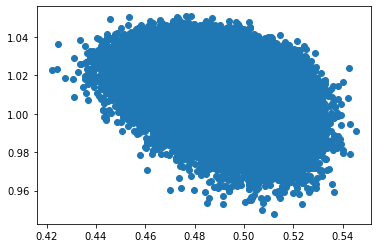

In [11]:
plt.scatter(beta_samples,alpha_samples)

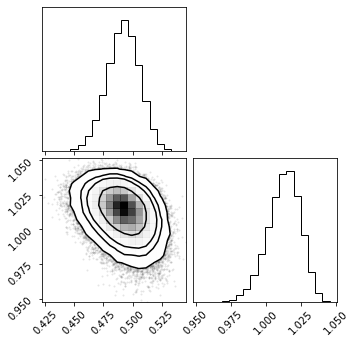

In [12]:
# Plot pymc3 samples as corner plot
samples = np.zeros((alpha_samples.size,2))
samples[:,0] = beta_samples
samples[:,1] = alpha_samples
figure = corner.corner(samples,levels=[0.68,0.9,0.955,0.99])
plt.savefig(fileout+'_corner.png')

In [13]:
alphas  = np.linspace(alphamin,alphamax,nalpha)
betas   = np.linspace(betamin,betamax,nbeta)
lnl     = np.zeros((nalpha,nbeta))
marg_beta  = np.sum(np.exp(lnl[:,:]),axis=0)
marg_alpha = np.sum(np.exp(lnl[:,:]),axis=1)

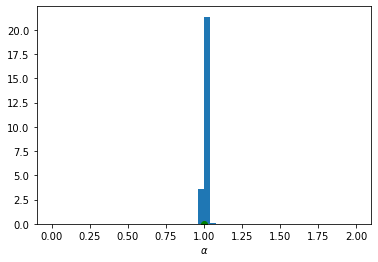

In [14]:
# Plot marginal distribution of alpha
# plt.plot(alphas,marg_alpha)
plt.hist(alpha_samples,bins=50,range=(alphamin,alphamax),density=True)
plt.xlabel('$\\alpha$')
plt.plot(alpha ,0,'go')

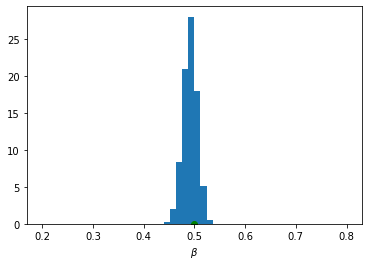

In [15]:
# Plot marginal distributions of beta
# plt.plot(betas,marg_beta)
plt.hist(beta_samples,bins=50,range=(betamin,betamax),density=True)
plt.xlabel('$\\beta$')
plt.plot(beta ,0,'go')